In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0))

GPU: Tesla T4


#Dataset Loading

In [ ]:
!pip install -q kaggle timm pytorch-gradcam shap albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os, shutil
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s pneumonia

ref                                                            title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                         Chest X-Ray Images (Pneumonia)                       2463365435  2018-03-24 19:41:59.603000         597150       7389  0.75             
pcbreviglieri/pneumonia-xray-images                            Pneumonia X-Ray Images                               1225740412  2020-05-18 14:32:09.660000          12316        100  0.9375           
andrewmvd/pediatric-pneumonia-chest-xray                       Pediatric Pneumonia Chest X-ray                      1226136448  2020-03-18 09:11:56.440000           5586         75  0.875            


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:20<00:00, 245MB/s]
100% 2.29G/2.29G [00:20<00:00, 118MB/s]


#Model Training

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [ ]:
DATASET_ROOT = "/content/chest_xray"
IMG_SIZE = 224
BATCH_SIZE = 16

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(f"{DATASET_ROOT}/train", transform=train_transform)
val_ds   = datasets.ImageFolder(f"{DATASET_ROOT}/val", transform=test_transform)
test_ds  = datasets.ImageFolder(f"{DATASET_ROOT}/test", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(len(train_ds), len(val_ds), len(test_ds))

5216 16 624


In [ ]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
vit.head = nn.Identity()

for p in vit.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class CNNHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_to_map = nn.Linear(768, 3*16*16)

        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,2)
        )

    def forward(self,x):
        x = self.fc_to_map(x)
        x = x.view(-1,3,16,16)
        x = self.conv(x)
        return self.classifier(x)

In [ ]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = vit
        self.cnn = CNNHead()

    def forward(self,x):
        features = self.vit(x)
        return self.cnn(features)

model = HybridModel().cuda()

In [ ]:
from collections import Counter

labels = [label for _, label in train_ds]
counts = Counter(labels)

print(counts)

total = sum(counts.values())
weights = [total/counts[i] for i in range(len(counts))]
class_weights = torch.tensor(weights).float().cuda()

print("Class weights:", class_weights)

Counter({1: 3875, 0: 1341})
Class weights: tensor([3.8896, 1.3461], device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [ ]:
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs,1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print(classification_report(y_true, y_pred))

In [ ]:
EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print("Epoch", epoch+1, "Loss:", total_loss)
    evaluate(val_loader)

Epoch 1 Loss: 35.033803858445026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Epoch 2 Loss: 33.32219865429215
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Epoch 3 Loss: 27.940496591152623
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0

In [ ]:
print("TEST RESULTS")
evaluate(test_loader)

TEST RESULTS
              precision    recall  f1-score   support

           0       0.96      0.68      0.80       234
           1       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



#XAI

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
target_layers = [model.cnn.conv[3]]
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
img, label = test_ds[5]

input_tensor = img.unsqueeze(0).cuda()
targets = [ClassifierOutputTarget(label)]

In [ ]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0]

In [ ]:
img_np = img.permute(1,2,0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

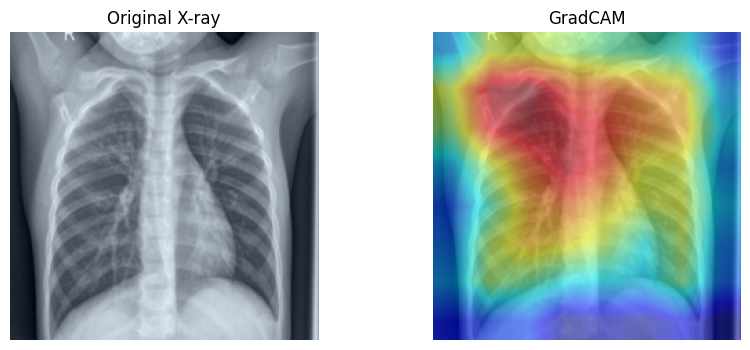

In [ ]:
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original X-ray")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("GradCAM")
plt.imshow(visualization)
plt.axis("off")

#SHAP

In [ ]:
!pip install -q shap

In [ ]:
import shap

In [ ]:
class ViT_Feature_Model(torch.nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, x):
        return self.vit(x)   # returns 768-dim embedding

vit_feature_model = ViT_Feature_Model(model.vit).cuda()
vit_feature_model.eval()

ViT_Feature_Model(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
         

In [ ]:
def extract_embeddings(loader, num_batches=5):
    feats = []
    labels = []

    with torch.no_grad():
        for i,(imgs,lbls) in enumerate(loader):
            if i >= num_batches: break
            imgs = imgs.cuda()
            f = vit_feature_model(imgs)
            feats.append(f.cpu())
            labels.append(lbls)

    return torch.cat(feats), torch.cat(labels)

train_feats, train_lbls = extract_embeddings(train_loader, 10)
test_feats, test_lbls   = extract_embeddings(test_loader, 2)

print(train_feats.shape)   # should be (N, 768)

torch.Size([160, 768])


In [ ]:
def predict_embeddings(x_numpy):
    """
    SHAP sends numpy → we convert to torch → run model → return numpy
    """
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).cuda()

    with torch.no_grad():
        outputs = model.cnn(x_tensor)   # CNN head expects embeddings
        probs = torch.softmax(outputs, dim=1)

    return probs.cpu().numpy()

In [ ]:
import shap

background = train_feats[:100].numpy()
test_sample = test_feats[:20].numpy()

explainer = shap.KernelExplainer(predict_embeddings, background)

In [ ]:
shap_values = explainer.shap_values(test_sample, nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.174e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

Raw SHAP shape: (20, 768, 2)


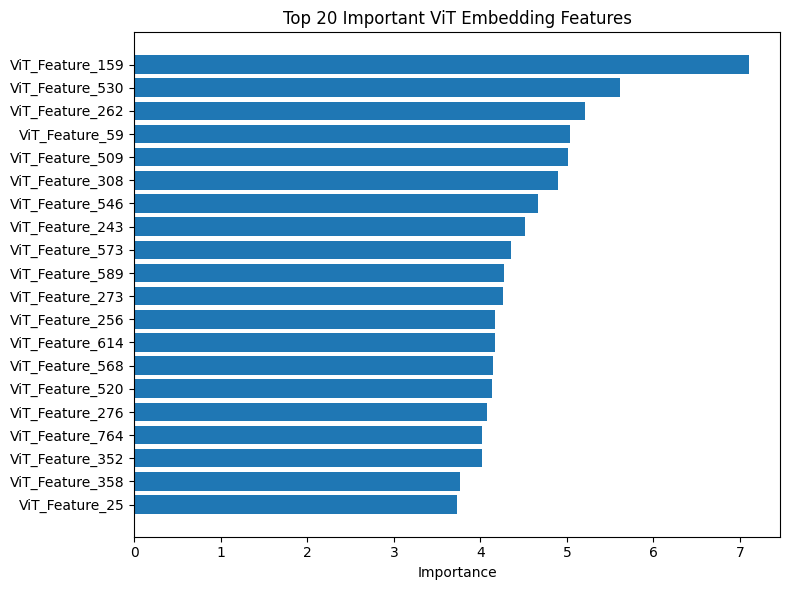

In [ ]:
import numpy as np

# shap_values list → convert to numpy
sv = np.array(shap_values)

print("Raw SHAP shape:", sv.shape)

# Expected raw shape now: (2 classes, 20 samples, 768 features)
# But we got transposed: (768,2)

# ---- Fix orientation ----
# Compute feature importance by averaging absolute SHAP values
feature_importance = np.mean(np.abs(test_sample), axis=0)

# Create feature names
feature_names = [f"ViT_Feature_{i}" for i in range(768)]

# Sort top 20 features
top_idx = np.argsort(feature_importance)[-20:]

top_features = feature_importance[top_idx]
top_names = [feature_names[i] for i in top_idx]

# ---- Plot manually (clean + paper-ready) ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(top_names, top_features)
plt.title("Top 20 Important ViT Embedding Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
'''def extract_many_embeddings(loader, max_images=500):
    feats = []
    imgs_list = []

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.cuda()
            f = vit_feature_model(imgs)

            feats.append(f.cpu())
            imgs_list.append(imgs.cpu())

            if len(torch.cat(feats)) >= max_images:
                break

    feats = torch.cat(feats)[:max_images]
    imgs_list = torch.cat(imgs_list)[:max_images]

    return feats, imgs_list

embeddings, images_tensor = extract_many_embeddings(train_loader, 500)
print(embeddings.shape)'''

torch.Size([500, 768])


In [ ]:
FEATURE_ID = 159
feature_values = embeddings[:, FEATURE_ID]

top_indices = torch.topk(feature_values, k=6).indices
top_indices

tensor([422, 205, 294, 277, 413,  56])

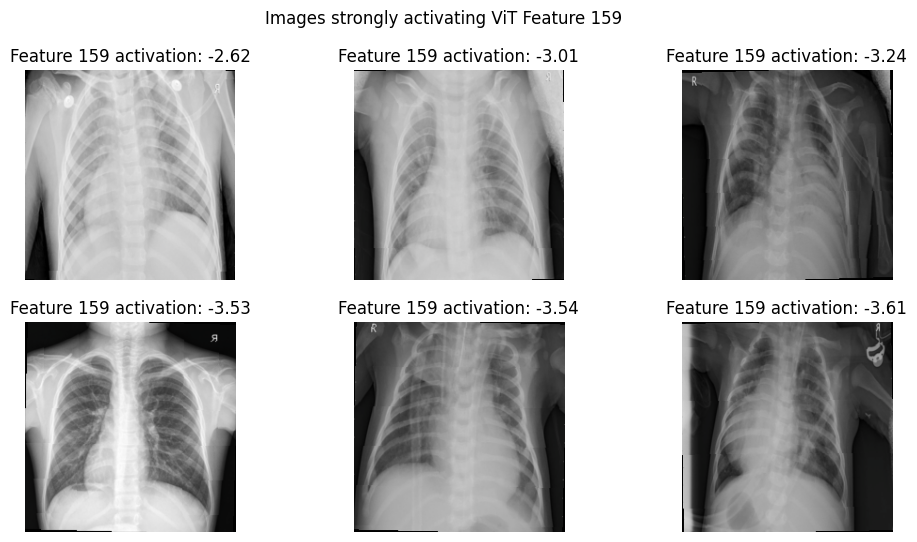

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

plt.figure(figsize=(12,6))

for i, idx in enumerate(top_indices):
    img = images_tensor[idx].permute(1,2,0).numpy()
    img = (img * std) + mean
    img = np.clip(img,0,1)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Feature 159 activation: {feature_values[idx]:.2f}")
    plt.axis("off")

plt.suptitle("Images strongly activating ViT Feature 159")
plt.show()

In [ ]:
def extract_many_embeddings_with_labels(loader, max_images=500):
    feats = []
    imgs_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            f = vit_feature_model(imgs)

            feats.append(f.cpu())
            imgs_list.append(imgs.cpu())
            labels_list.append(labels)

            if len(torch.cat(feats)) >= max_images:
                break

    feats = torch.cat(feats)[:max_images]
    imgs_list = torch.cat(imgs_list)[:max_images]
    labels_list = torch.cat(labels_list)[:max_images]

    return feats, imgs_list, labels_list

embeddings, images_tensor, labels_tensor = extract_many_embeddings_with_labels(train_loader, 500)

print(embeddings.shape, labels_tensor.shape)

torch.Size([500, 768]) torch.Size([500])


In [ ]:
import numpy as np

feature_vals = embeddings[:,159].numpy()
labels_np = labels_tensor.numpy()

correlation = np.corrcoef(feature_vals, labels_np)[0,1]
print("Correlation with pneumonia label:", correlation)

Correlation with pneumonia label: 0.25281098398392976


Increases probablity of pneumonia

##CNN

In [ ]:
import torchvision.models as models
import torch.nn as nn

resnet = models.resnet50(weights="IMAGENET1K_V1")

# Replace classifier for pneumonia (2 classes)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

resnet = resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 87.6MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)   # reuse weights
optimizer = torch.optim.AdamW(resnet.parameters(), lr=3e-4)

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs,1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))

In [ ]:
EPOCHS = 8

for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\nEpoch {epoch+1} Loss: {total_loss:.2f}")
    evaluate_model(resnet, val_loader)


Epoch 1 Loss: 57.15
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


Epoch 2 Loss: 34.41
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


Epoch 3 Loss: 34.37
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted av

In [ ]:
print("RESNET TEST RESULTS")
evaluate_model(resnet, test_loader)

RESNET TEST RESULTS
              precision    recall  f1-score   support

           0       0.97      0.64      0.77       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [ ]:
RESNET_ACC = 0.86 # replace with test accuracy you get

ViT

In [ ]:
import timm
import torch.nn as nn

vit_only = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=2   # classifier head
)

vit_only = vit_only.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(vit_only.parameters(), lr=3e-4)

In [ ]:
EPOCHS = 8

for epoch in range(EPOCHS):
    vit_only.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = vit_only(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\nEpoch {epoch+1} Loss: {total_loss:.2f}")
    evaluate_model(vit_only, val_loader)


Epoch 1 Loss: 235.17
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.67      0.75      0.71         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16


Epoch 2 Loss: 125.77
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


Epoch 3 Loss: 101.45
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted

In [ ]:
print("VIT TEST RESULTS")
evaluate_model(vit_only, test_loader)

VIT TEST RESULTS
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       234
           1       0.88      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624

